## Problem Statement
Build a model with 250 data points in the train set and predict the binary target accurately for 19750 unseen data points in the test set. The dataset has 300 features.

## Objectives
- Perfrom EDA on dataset
- Perform Feature Engineering on the dataset
- Ensure that the model does not overfit
- Get a score better than 0.8 on the kaggle leaderboard

## Introduction
This project is aimed at correcting the notion that kaggle competition models overfit. The project is suppose to test measures to ensure that the data does not overfit, that is why it is important to understand the dataset well through EDA and Engineer the right features for the data.

In [25]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier

warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
#read files
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [27]:
df_train.shape, df_test.shape

((250, 302), (19750, 301))

In [28]:
set(df_train.columns) - set(df_test.columns)

{'target'}

In [29]:
df_train.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [31]:
#check for missing values
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 302 entries, id to 299
dtypes: float64(301), int64(1)
memory usage: 590.0 KB


#### Observations
- Dataset has 300 independent features (0-299) and a binary target variable.
- All values of the features are continuous
- There are 250 entries of data
- There are no missing values.
- There are no columns with dtype of objects, hence, encoding techniques might not be necessary here.
- The target variable has to be dropped
- The Id column would also not be used in the model.

## EDA

Since the data contains mainly numerical variables, we will try to perform Probability Density Function (PDF) to see the probability of values that they are likely to assume.

### Univariate analysis

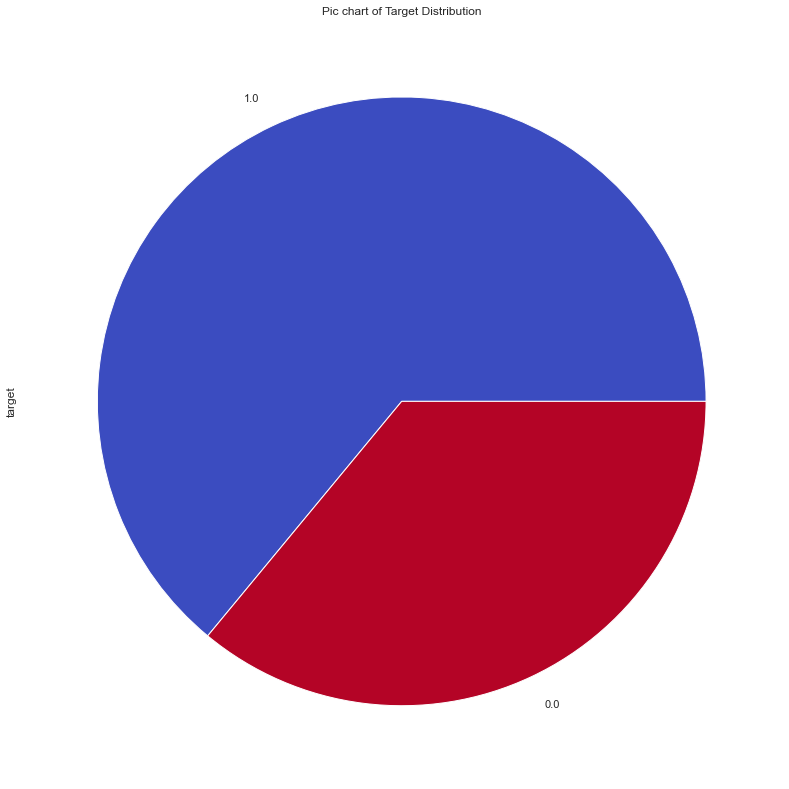

In [63]:
# Target
plt.subplot(1,2,2)
ax = df_train['target'].value_counts().plot(kind='pie', colormap='coolwarm')
ax.set_title('Pic chart of Target Distribution');

The dataset is imbalanced, from the visuals above we can see that the ratio of target 1 to target 0 is 0.64:0.36, i.e target 1 almost twice more than target 0.

Let's check for skewness of data

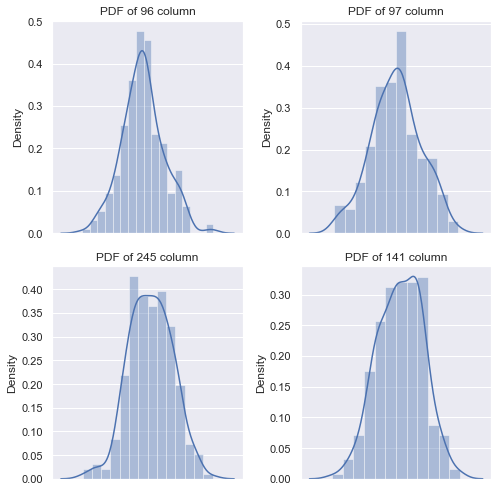

In [34]:
#we will select 4 random columns from the dataset
fig, axes = plt.subplots(2,2, figsize=(7,7))
r = np.random.randint(0,299,4,dtype=int)

sns.distplot(df_train[str(r[0])], ax=axes[0,0])
axes[0,0].set_title(f'PDF of {r[0]} column')
axes[0,0].get_xaxis().set_visible(False)

sns.distplot(df_train[str(r[1])], ax=axes[0,1])
axes[0,1].set_title(f'PDF of {r[1]} column')
axes[0,1].get_xaxis().set_visible(False)

sns.distplot(df_train[str(r[2])], ax=axes[1,0])
axes[1,0].set_title(f'PDF of {r[2]} column')
axes[1,0].get_xaxis().set_visible(False)

sns.distplot(df_train[str(r[3])], ax=axes[1,1])
axes[1,1].set_title(f'PDF of {r[3]} column')
axes[1,1].get_xaxis().set_visible(False)

fig.tight_layout()
plt.show();

After running for multiple times, the plot majorly assumes a **Normal Distribution** i.e they are approximately symmetric but not perfectly symmetric

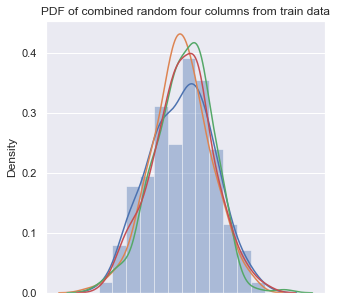

In [35]:
# Let's try to overlapping the pdf
plt.figure(figsize=(5,5))
r = np.random.randint(0,299,4,dtype=int)

sns.distplot(df_train[str(r[0])], hist=True, label=str(r[0]))
sns.distplot(df_train[str(r[1])], hist=False, label=str(r[1]))
sns.distplot(df_train[str(r[2])], hist=False, label=str(r[2]))
sns.distplot(df_train[str(r[3])], hist=False, label=str(r[3]))

plt.title('PDF of combined random four columns from train data')
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

PDF of 217 column on target based value


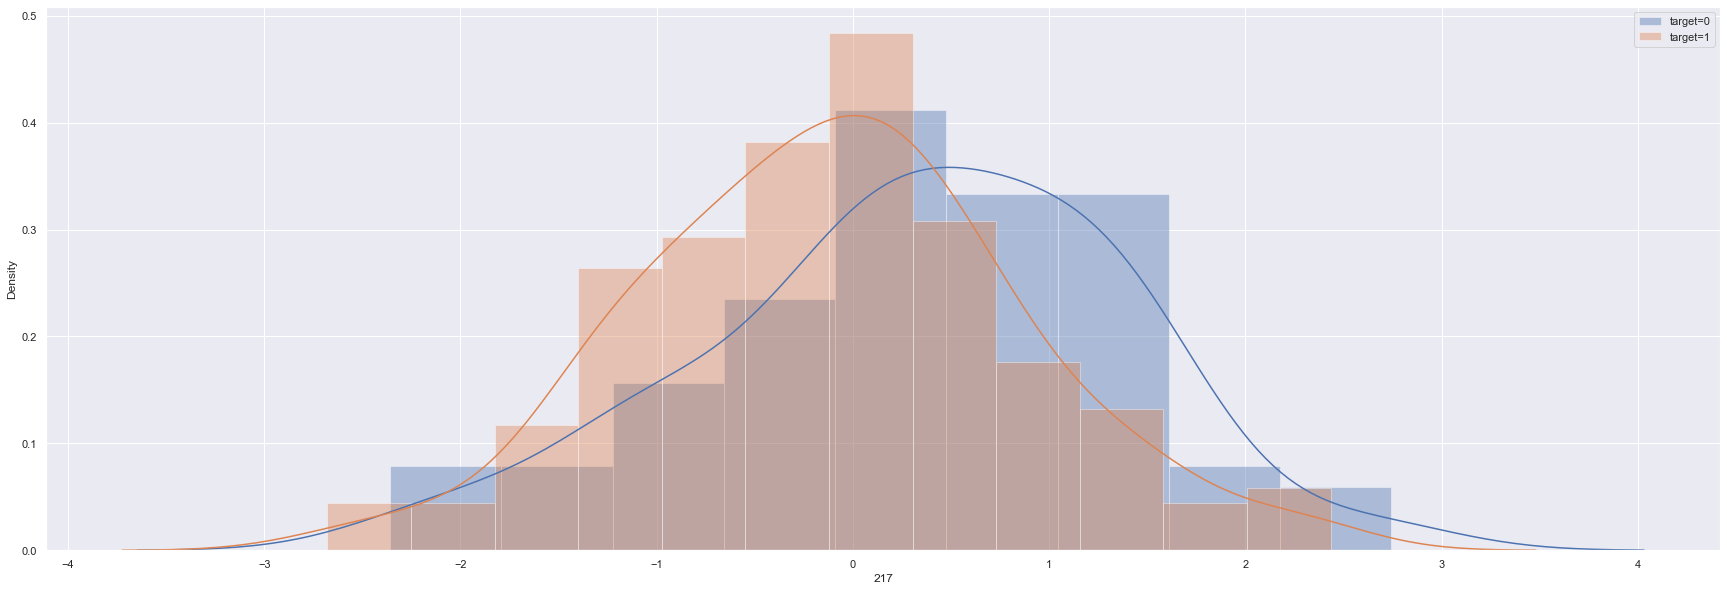

In [36]:
# PDF based on target

r = np.random.randint(0,299,1,dtype=int)

sns.distplot(df_train[df_train['target']==0][str(r[0])], label='target=0')
sns.distplot(df_train[df_train['target']==1][str(r[0])], label='target=1')
print(f'PDF of {r[0]} column on target based value')

plt.legend()
plt.show()

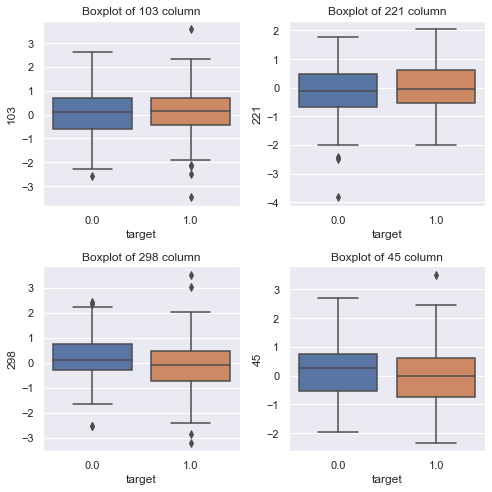

In [37]:
fig, axes = plt.subplots(2,2, figsize=(7,7))
r = np.random.randint(0,299,4,dtype=int)

sns.boxplot(data=df_train, x='target', y=str(r[0]), ax=axes[0,0])
axes[0,0].set_title('Boxplot of {} column'.format(r[0]))

sns.boxplot(data=df_train, x='target', y=str(r[1]), ax=axes[0,1])
axes[0,1].set_title('Boxplot of {} column'.format(r[1]))

sns.boxplot(data=df_train, x='target', y=str(r[2]), ax=axes[1,0])
axes[1,0].set_title('Boxplot of {} column'.format(r[2]))

sns.boxplot(data=df_train, x='target', y=str(r[3]), ax=axes[1,1])
axes[1,1].set_title('Boxplot of {} column'.format(r[3]))

fig.tight_layout()
plt.show()

After running for several random , we can say that:
- The distribution of the features are almost identical
- They also have close mean

In [38]:
# Since the featires are a lot, we will check ffor top correlated values.
correlations = df_train.drop(['id'], axis=1).corr().unstack().drop_duplicates()
print('Top 10 positive correlated features with target:')
print(correlations["target"].sort_values(ascending=False)[:10])
print('-'*100)
print('Top 10 negative correlated features with target:',)
print(correlations["target"].sort_values(ascending=True)[:10])

Top 10 positive correlated features with target:
target    1.000000
33        0.373608
65        0.293846
24        0.173096
183       0.164146
199       0.159442
201       0.142238
30        0.132705
289       0.127213
114       0.124792
dtype: float64
----------------------------------------------------------------------------------------------------
Top 10 negative correlated features with target:
217   -0.207215
117   -0.197496
91    -0.192536
295   -0.170501
73    -0.167557
80    -0.162558
189   -0.155956
194   -0.150384
16    -0.144267
39    -0.142915
dtype: float64


It is easy to see that the features are not correlated with the target, i.e corellation is between [-0.2, 0.2]

Let's plot visuals for that

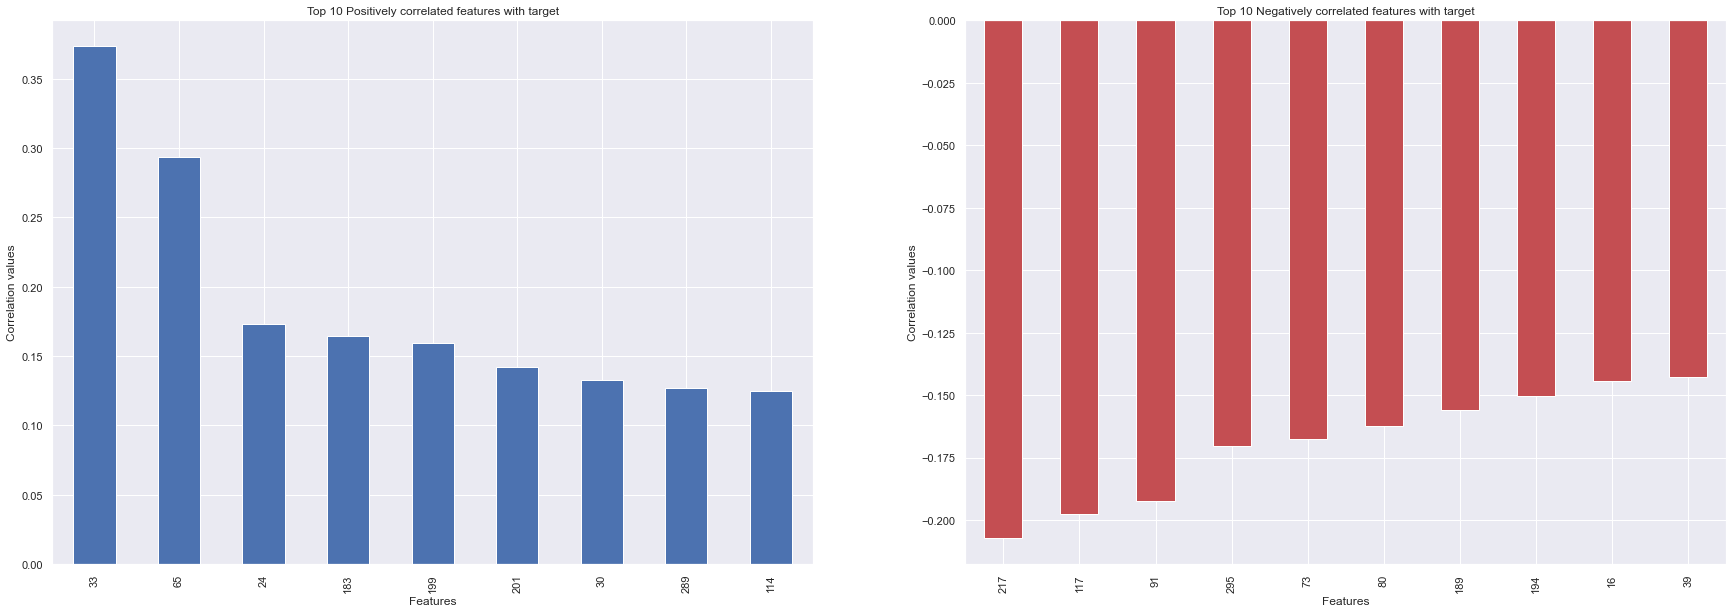

In [39]:
correlations = df_train.drop(['id'], axis=1).corr().unstack().drop_duplicates()
sns.set(rc={'figure.figsize':(30,10)})
plt.subplot(1,2,1)
x = correlations["target"].sort_values(ascending=False)[1:10].plot(kind='bar', title='Top 10 Positively correlated features with target')
x.set_xlabel('Features')
x.set_ylabel('Correlation values')

plt.subplot(1,2,2)
x = correlations["target"].sort_values(ascending=True)[:10].plot(kind='bar', title='Top 10 Negatively correlated features with target', color='r')
x.set_xlabel('Features')
x.set_ylabel('Correlation values');

#### PCA
Let's check for linear seperability of model using PCA

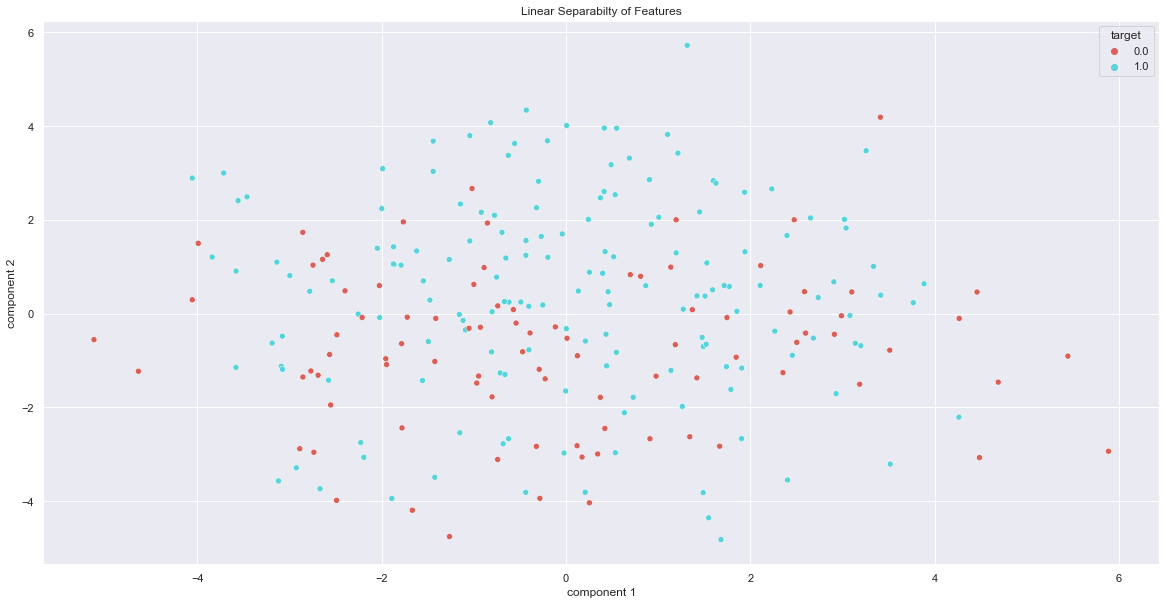

In [40]:
sns.set(rc={'figure.figsize':(20,10)})
pca = PCA(n_components=3, svd_solver='full')
pca_result = pca.fit_transform(df_train.drop(['id','target'], axis=1).values)
x = pca_result[:,0]
y = pca_result[:,1]
ax = sns.scatterplot(x, y, hue = df_train['target'], palette=sns.color_palette("hls", 2), legend="full", alpha=1)
ax.set_title('Linear Separabilty of Features')
ax.set_xlabel('component 1')
ax.set_ylabel('component 2');

The features are not linearly separable

#### Observations
- The dataset has very small rows
- The imbalance in the data would not affect the data since it is not highly imbalanced
- The feature have no categorical features and have a distribution close to normal distrubution, hence, might not require complex preprocessing.


## Modeling

In [41]:
X = df_train.drop(['id','target'], axis=1)
y = df_train['target']
submission = pd.read_csv('sample_submission.csv')
test = df_test.drop(['id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.04, stratify=y, random_state=42) 
print('X_train, y_train shape: ',X_train.shape, y_train.shape)
print('X_test, y_test shape: ',X_test.shape, y_test.shape)
print('test_shape: ',test.shape)
print('submission_shape: ',submission.shape)

X_train, y_train shape:  (240, 300) (240,)
X_test, y_test shape:  (10, 300) (10,)
test_shape:  (19750, 300)
submission_shape:  (19750, 2)


In [42]:
def scale(X_train, X_test, test) -> pd.DataFrame:
    '''
    Normalize the input varaible

    X_train: train variable
    X_test: test variable
    test: Submission test Variable

    Return:
    Scaled/Normalized values of each varaibles
    '''
    scaler  = StandardScaler()
    X_train  = scaler.fit_transform(X_train)
    test = scaler.transform(test)
    X_test = scaler.transform(X_test)
    return X_train, X_test, test

In [43]:
def plot_roc(train_true, train_pred, test_true, test_pred, axis, model_name, cv_score, train_acc, test_acc, n_classes=2):
    '''
    Compute ROC curve and ROC area for each class
    
    Parameters:
    train_true: train true label
    train_pred: train predict probabilities value
    test_true: Sample Test true label
    test_pred: Sample Test predict probabilities value
    axis: axis of plot
    model_name: Name of Model curve
    cv_score: CV score of model
    train_acc: Train accuracy of Model
    test_acc: Test accuracy of Model
    n_classes: number of unique classes
    
    Return:
    Nothing   
    '''
    # For train
    tr_fpr = dict()
    tr_tpr = dict()
    tr_roc_auc = dict()
    for i in range(n_classes):
        tr_fpr[i], tr_tpr[i], _ = roc_curve(train_true, train_pred[:, i])
        tr_roc_auc[i] = auc(tr_fpr[i], tr_tpr[i])

    # For Sample Test
    te_fpr = dict()
    te_tpr = dict()
    te_roc_auc = dict()
    for i in range(n_classes):
        te_fpr[i], te_tpr[i], _ = roc_curve(test_true, test_pred[:, i])
        te_roc_auc[i] = auc(te_fpr[i], te_tpr[i])

    # Plot roc for train
    axis.plot(tr_fpr[1], tr_tpr[1], color='red', alpha=0.5, 
            lw=2, label='ROC curve for Train (area = %0.2f)' % tr_roc_auc[1])
    # Plot roc for Sample Test
    axis.plot(te_fpr[1], te_tpr[1], color='green', alpha=0.5, 
            lw=2, label='ROC curve for Sample Test (area = %0.2f)' % te_roc_auc[1])
    axis.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axis.set_xlim([0.0, 1.0])
    axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('False Positive Rate')
    axis.set_ylabel('True Positive Rate')
    axis.set_title(model_name+' Receiver operating characteristic: train vs Sample Test')
    axis.legend(loc="lower right")

    axis.text(x=1.0, y=0.40, transform=axis.transAxes, s="Mean CV ROC_AUC: {:.4f}".format(cv_score),\
            fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='r')
    axis.text(x=1.0, y=0.34, transform=axis.transAxes, s="Train Accuracy: {:.4f}".format(train_acc),\
            fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='b')
    axis.text(x=1.0, y=0.28, transform=axis.transAxes, s="Sample Test Accuracy: {:.4f}".format(test_acc),\
            fontweight='demibold', fontsize=12, verticalalignment='top', horizontalalignment='right',\
            backgroundcolor='white', color='g')

In [44]:
def model_data() -> list:
    '''
    There are total 8 algorithm with list of their hyperparameters
    1. Logistic Regression (linear)
    2. Linear Discriminate Analysis(linear)
    3. K Neighbors Classifiers (non-linear)
    4. Decision Tree (non-linear)
    5. Naive Bayes (non-linear)
    6. Support Vector Classifiers (non-linear)
    7. Random Forest (non-linear)
    8. XGBoost (non-linear)

    Return:
    all the models along with their name, list of hyperparamaters and short_name
    '''
    # Hyperparameters for Logistic Regression
    LRparams = {
        "class_weight":["balanced"],
        "penalty" : ["l2","l1"],
        "tol" : [0.0001,0.0002,0.0003],
        "max_iter": [100,200,300,500],
        "C" :[0.001,0.01, 0.1, 1, 10, 100],
        "intercept_scaling": [1, 2, 3, 4,5],
        "solver":["liblinear"],
    }
    # Hyperparameters for Linear Discriminate Analysis
    LDAparams = {
        "solver" : ["svd"],
        "tol" : [0.0001,0.0002,0.0003]
    }
    # Hyperparameters for K Neighbors Classifiers
    KNNparams = {
        'n_neighbors':[5,6,7,8,9,10],
        'leaf_size':[1,2,3,5],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute'],
        'n_jobs':[-1]
    }
    # Hyperparameters for Decision Tree
    DTparams = {
        "max_depth": [3, 5 , 10, None],
        "max_features": ["auto", "sqrt", "log2", None],
        "min_samples_leaf": [1,5,10,50],
        "criterion": ["gini", "entropy"],
        "class_weight":["balanced"]
    }
    # Hyperparameters for Naive Bayes
    NBparams = {
        'var_smoothing': np.logspace(0,-9, num=100)   
    }
    # Hyperparameters for Support Vector Classifiers
    SVCparams = {
        'kernel': ['rbf','linear'], 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,'auto'],
        'C': [1, 6, 7, 8, 9, 10, 11, 12, 10, 50, 100, 200, 300],
        'class_weight': ['balanced'],
        'probability': [True]
    }
    # Hyperparameters for Random Forest
    RFparams = {
        'criterion':['gini','entropy'],
        'n_estimators':[10,15,20,25,30],
        'min_samples_leaf':[1,2,3,4,5],
        'min_samples_split':[3,4,5,6,7], 
        'n_jobs':[-1],
        'class_weight' : ["balanced", "balanced_subsample"]
    }
    # Hyperparameters for XGBoost
    XGBparams={
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
        'n_estimators':[10,20,30,40,100],
        'max_depth':[2,3,5,10],
        'colsample_bytree':[0.1,0.3,0.5,1],
        'subsample':[0.1,0.3,0.5,1],
        'n_jobs':[-1],
    }
    # Models
    models = []
    models.append(('Logistic Regression', LogisticRegression(random_state=42), LRparams,'LR'))
    models.append(('Linear Discriminate Analysis', LinearDiscriminantAnalysis(), LDAparams,'LDA'))
    models.append(('K Neighbors Classifiers', KNeighborsClassifier(), KNNparams,'KNN'))
    models.append(('Decision Tree', DecisionTreeClassifier(random_state=42), DTparams,'DT'))
    models.append(('Naive Bayes', GaussianNB(), NBparams,'NB'))
    models.append(('Support Vector Classifiers', SVC(random_state=42), SVCparams,'SVC'))
    models.append(('Random Forest', RandomForestClassifier(random_state=42), RFparams,'RF'))
    models.append(('XGBoost', XGBClassifier(random_state=42), XGBparams,'XGB'))
    return models

In [54]:
def save_test_result(pred, modelname):

    '''
    Create a dataframe of submission ids and respective predicted probability
    and save into localdisk

    pred: predictions of model
    modeltype: type of model
    modelname: name of classifiers

    Return:
    Nothing
    '''
    if not os.path.isdir('result/'):
        os.mkdir('result/')

    id = submission['id']
    test_df = pd.DataFrame(np.column_stack((id,pred)), columns=['id','target'])
    test_df['id'] = test_df['id'].astype('int32')
    test_df.to_csv('result/'+'/'+'_'+modelname+'submit.csv', index=False)

In [58]:
def save_model(model, modelname):
    '''
    It will save to trained model into drive for use in future
    model: classifiers
    modelname: name of classifiers

    Return:
    Nothing
    '''
    if not os.path.isdir('SavedModel/'):
        os.mkdir('SavedModel/')
        
    filename = 'SavedModel/'+'/'+'_'+modelname+'model.sav'
    joblib.dump(model, filename)

In [59]:
def trainWithBestModelAndParams(X_train, X_test, y_train, y_test, Test = test, CV=5, Scaling=True) :
    '''
    Select Best ML model with their best hyperparamaters
    
    Parameters:
    X_train: train data
    X_test: sample test data
    y_train: train true label
    y_test: sample Test true label
    Test: test data for submission
    CV: number of cross-validation folds
    Scaling: For Scaling of Input varaibles 
    
    Return:
    Best Classifiers   
    '''
    models = model_data()
    # Scaling Features
    if Scaling:
        X_train, X_test, Test = scale(X_train, X_test, Test)

    #RandomSearch    
    result = []
    print('Estimator Score,Best Parameters')
    print('-'*180)
    for name, model, params, abr in models:
        rs=RandomizedSearchCV(model ,param_distributions = params ,verbose=0, n_jobs=-1, scoring='roc_auc',cv = CV, n_iter=10, random_state=42)
        rs.fit(X_train,y_train)
        result.append((name, rs.best_score_, rs.best_params_, rs.best_estimator_, abr))
        print('{:31}| {:.4f} | {}'.format(name, rs.best_score_, rs.best_params_))

    # Selecting Best Score Model
    mx = -1
    best_model = 0
    for i in result:
        if(i[1]>mx):
            mx = i[1]
            best_model = i
    print('_'*180)
    print(f'Best Model, {best_model[0]}')
    print(f'CV Score, {best_model[1]}')
    print(f'Parameters, {best_model[2]}')
    print(f'Estimator, {best_model[3]}')
    print('_'*180)
    
    #Training Models
    print('Training Models..')
    sns.set(rc={'figure.figsize':(30,30)})
    fig, ax = plt.subplots(4, 2,sharex='col', sharey='row')
    ax = ax.reshape(-1)

    classifiers = []
    for i, model in enumerate(result):
        clf = model[3]
        clf = CalibratedClassifierCV(clf, cv=10, method='sigmoid')
        clf.fit(X_train,y_train)

        #Save Model into disk
        save_model(clf, model[4])

        #Append classifier into list
        classifiers.append((model[0], clf))

        #Predicting
        pred = clf.predict_proba(Test)[:,1]

        #Saving prediction into disk
        save_test_result(pred, model[4])

        #Plotting ROC AUC
        plot_roc(y_train, clf.predict_proba(X_train), y_test, clf.predict_proba(X_test),\
                 ax[i], model[0], model[1], clf.score(X_train,y_train), clf.score(X_test, y_test), n_classes=2)

        print(model[0]+' done.')
    print('_'*180)
    print('Plotting ROC curve')
    plt.show()
    classifiers = dict(classifiers)
    return best_model, classifiers

Estimator Score,Best Parameters
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression            | 0.7945 | {'tol': 0.0002, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'intercept_scaling': 5, 'class_weight': 'balanced', 'C': 0.1}


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Linear Discriminate Analysis   | 0.7165 | {'tol': 0.0001, 'solver': 'svd'}
K Neighbors Classifiers        | 0.6088 | {'weights': 'distance', 'n_neighbors': 9, 'n_jobs': -1, 'leaf_size': 5, 'algorithm': 'auto'}
Decision Tree                  | 0.6387 | {'min_samples_leaf': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
Naive Bayes                    | 0.7586 | {'var_smoothing': 1.0}
Support Vector Classifiers     | 0.7621 | {'probability': True, 'kernel': 'rbf', 'gamma': 'auto', 'class_weight': 'balanced', 'C': 11}
Random Forest                  | 0.6697 | {'n_jobs': -1, 'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost                        | 0.7718 | {'subsample': 0.5, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1}
____________________________________________________________________________________________________________________________________________________________________________________
Best Model, Logistic Regression
CV Score, 0.7944802867383511
Parameters, {'tol': 0.0002, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'intercept_scaling': 5, 'class_weight': 'balanced', 'C': 0.1}
Estimator, LogisticRegression(C=0.1, class_weight='balanced', intercept_scaling=5,
         

/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:54] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/lindaoranya/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:40:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost done.
____________________________________________________________________________________________________________________________________________________________________________________
Plotting ROC curve


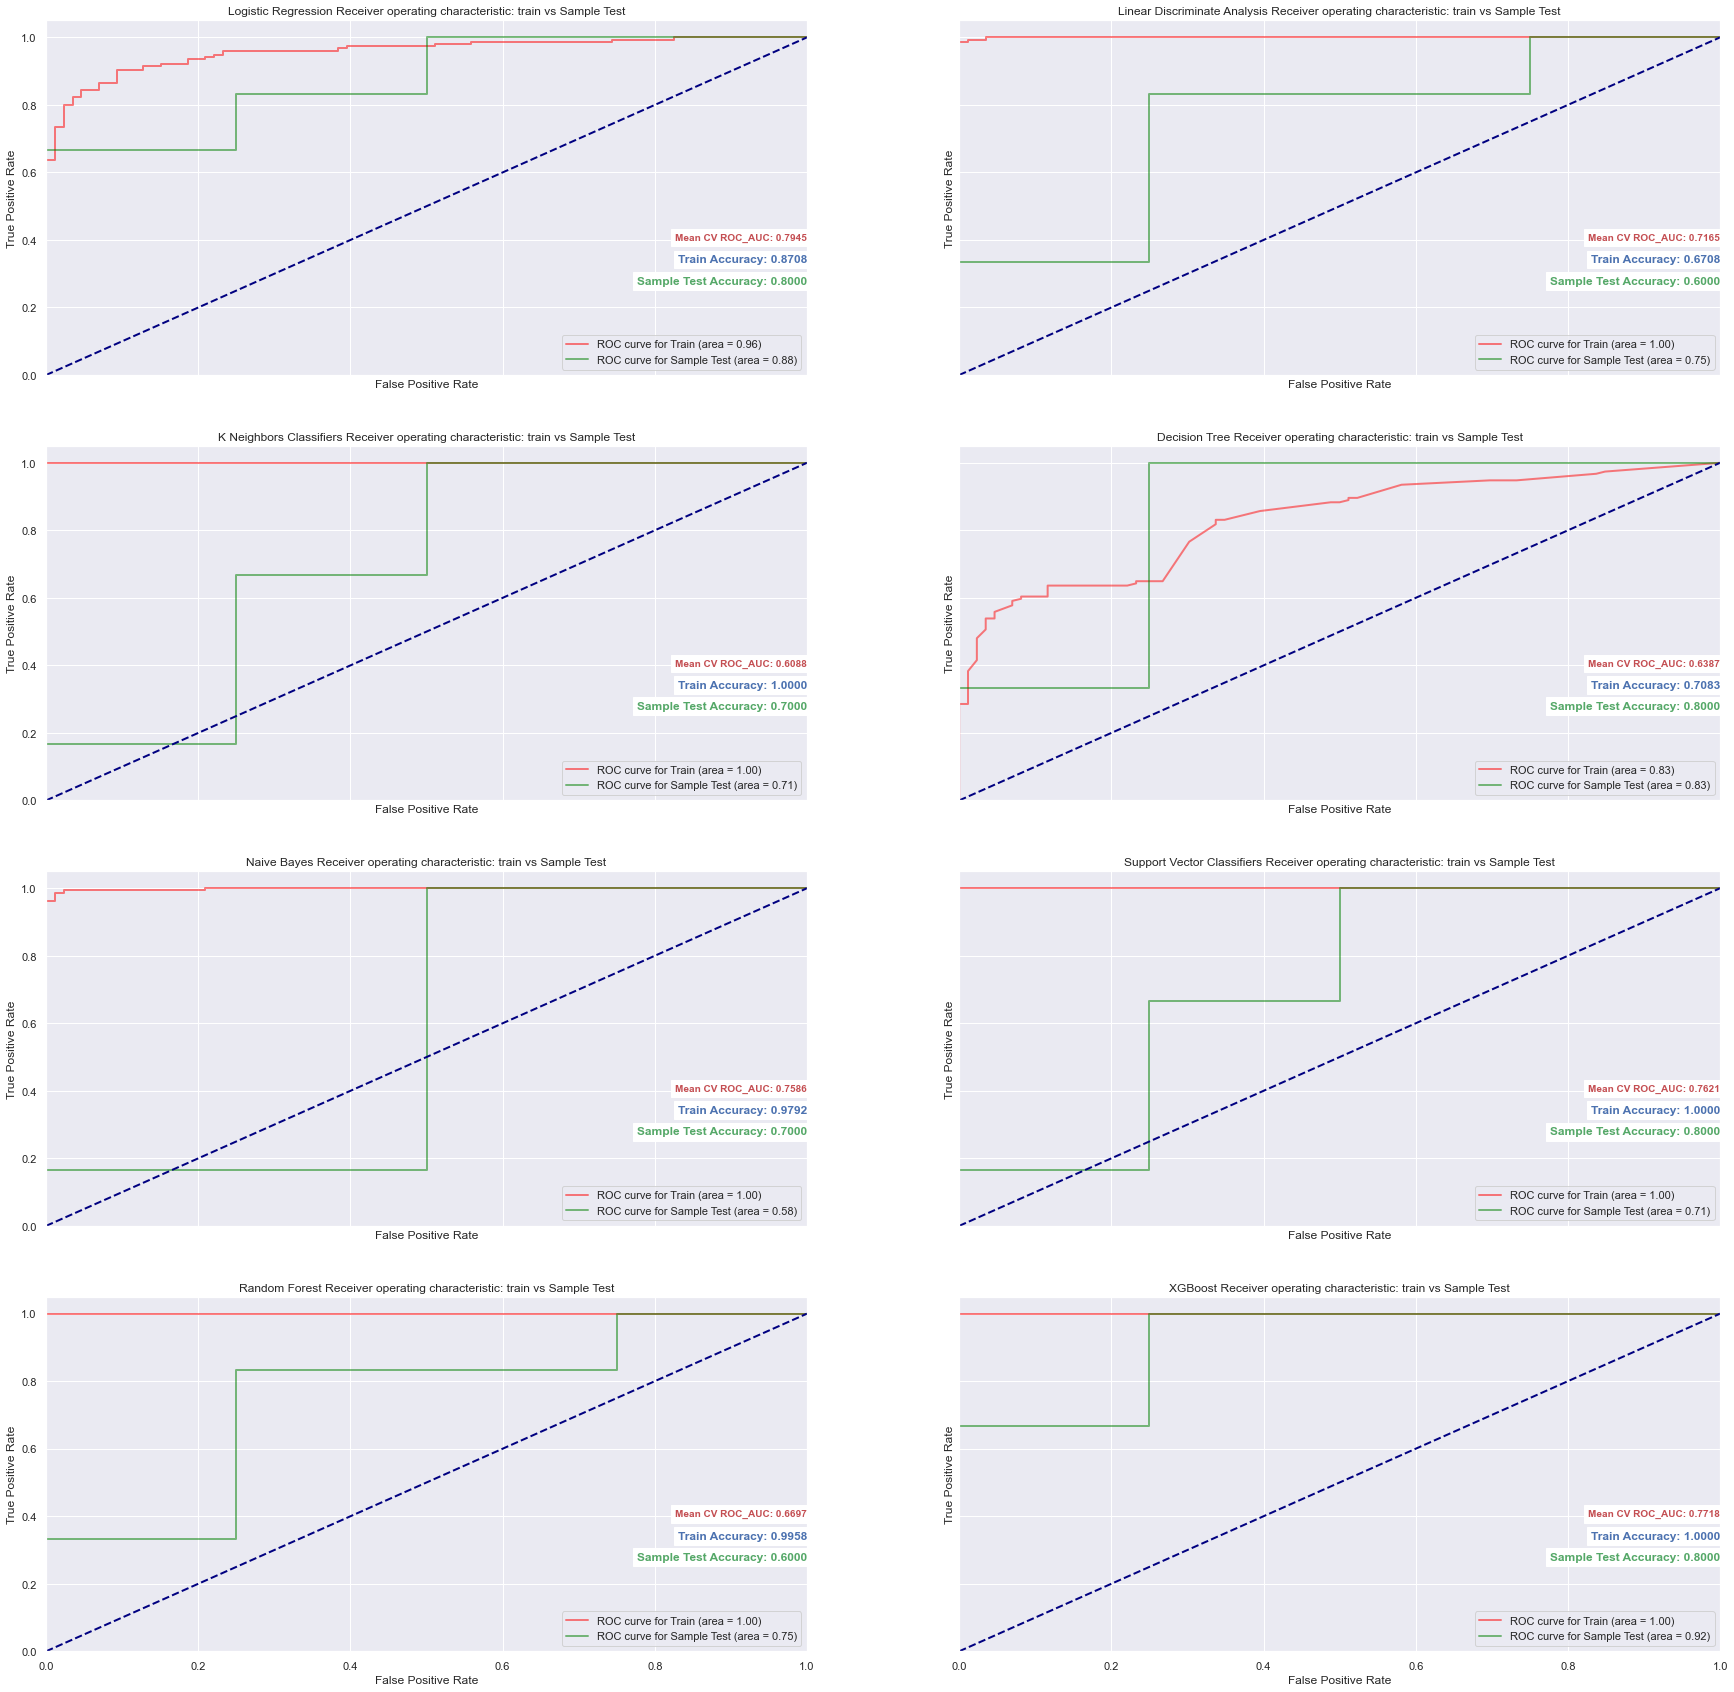

In [60]:
baseline_best_model, BM_clfs = trainWithBestModelAndParams(X_train, X_test, y_train, y_test, test, CV=5)

In [61]:
baseline_best_model

('Logistic Regression',
 0.7944802867383511,
 {'tol': 0.0002,
  'solver': 'liblinear',
  'penalty': 'l1',
  'max_iter': 100,
  'intercept_scaling': 5,
  'class_weight': 'balanced',
  'C': 0.1},
 LogisticRegression(C=0.1, class_weight='balanced', intercept_scaling=5,
                    penalty='l1', random_state=42, solver='liblinear',
                    tol=0.0002),
 'LR')

In [64]:
modelnames = ['Logistic Regression','Linear Discriminate Analysis','K Neighbors','Decision Tree','Naive Bayes','SVC',
              'Random Forest','XGBoost']
pri_kag_score = [0.82,0.61,0.68,0.65,0.66,0.70,0.66,0.72]
pub_kaggle_score = [0.83,0.64,0.60,0.66,0.71,0.74,0.70,0.78]
score = [0.79,0.72,0.61,0.64,0.76,0.76,0.68,0.77]
pd.DataFrame({'model':modelnames,'score':score,'private kaggle score':pri_kag_score,'public kaggle_score':pub_kaggle_score})

,model,score,private kaggle score,public kaggle_score
0,Logistic Regression,0.79,0.82,0.83
1,Linear Discriminate Analysis,0.72,0.61,0.64
2,K Neighbors,0.61,0.68,0.60
3,Decision Tree,0.64,0.65,0.66
4,Naive Bayes,0.76,0.66,0.71
5,SVC,0.76,0.70,0.74
6,Random Forest,0.68,0.66,0.70
7,XGBoost,0.77,0.72,0.78


## Conclusion

The Logistic Regression performed better, overall, the model did not overfit as it still gives a good score for the test data. 
My assumption would be that LR works well because the data is a simple data and a complex one may lead to overfitting.


The dataset is a small and random one, but Feature Engineering, such as Feature crossing could be done on the data.